c:\Users\Hatlab - IY\anaconda3\envs\qutip-env\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
[Parallel(n_jobs=28)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done   5 tasks      | elapsed:   24.7s
[Parallel(n_jobs=28)]: Done  16 tasks      | elapsed:   25.0s
[Parallel(n_jobs=28)]: Done  29 tasks      | elapsed:   48.9s
[Parallel(n_jobs=28)]: Done  42 tasks      | elapsed:   49.9s
[Parallel(n_jobs=28)]: Done  57 tasks      | elapsed:  1.0min
[Parallel(n_jobs=28)]: Done  72 tasks      | elapsed:  1.0min
[Parallel(n_jobs=28)]: Done  89 tasks      | elapsed:  1.2min
[Parallel(n_jobs=28)]: Done 106 tasks      | elapsed:  1.2min
[Parallel(n_jobs=28)]: Done 125 tasks      | elapsed:  1.4min
[Parallel(n_jobs=28)]: Done 144 tasks      | elapsed:  1.6min
[Parallel(n_jobs=28)]: Done 165 tasks      | elapsed:  1.8min
[Parallel(n_jobs=28)]: Don

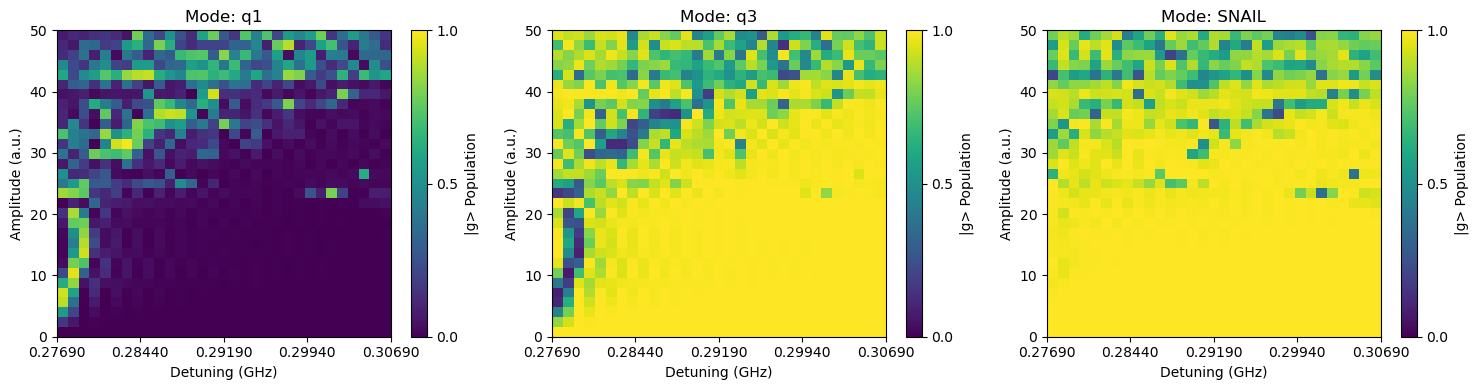

In [ ]:
from joblib import Parallel, delayed
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from hamiltonian import QuantumSystem, Hamiltonian, Pulse
import data_processing as dp
import helper

PI = np.pi
rad_to_GHz = 1 / (2 * PI)
opts = qt.Options(nsteps=1e6, atol=1e-8, rtol=1e-6)
p_bar = qt.ui.TextProgressBar()

yaml_file = r"system_params_20231205.yaml"
system_info = dp.load_yaml(yaml_file)

data_path = "./data//"
data_name = "Q2Q4_TLS_0.5us_amp_freq_Sdim10"

width_d = 500

N = 31
detunelist = 2 * PI * (np.linspace(0, 0.03, N))
alist = np.linspace(0, 50, N)


def simulation_task(freq_amp_tuple, hamiltonian, psi0, t_list, pulse_args):
    freq, amp = freq_amp_tuple
    pulse = Pulse(omega=freq, amp=amp)
    snail_mode = hamiltonian.system.get_mode("SNAIL")
    snail_field = hamiltonian.system.modes_field[snail_mode]
    H_drive = [hamiltonian.H, [snail_field, pulse.drive]]
    solve_result = qt.mesolve(H_drive, psi0, t_list, args=pulse_args, options=opts)
    final_state = solve_result.states[-1]
    return final_state


def simulation_task2(freq_amp_tuple, hamiltonian, psi0, t_list, pulse_args):
    # try simulating the system after diagnalization and including different 3rd order terms
    gd1 = 0.2260
    gd2 = 0.1332
    g3 = 0.2487

    freq, amp = freq_amp_tuple
    pulse = Pulse(omega=freq, amp=amp)
    snail_mode = hamiltonian.system.get_mode("SNAIL")
    snail_field = hamiltonian.system.modes_field[snail_mode]

    _s = hamiltonian.system.modes_a[snail_mode]
    _sd = hamiltonian.system.modes_a_dag[snail_mode]
    _q1 = hamiltonian.system.modes_a[hamiltonian.system.get_mode("q1")]
    _q1d = hamiltonian.system.modes_a_dag[hamiltonian.system.get_mode("q1")]
    _q2 = hamiltonian.system.modes_a[hamiltonian.system.get_mode("q3")]
    _q2d = hamiltonian.system.modes_a_dag[hamiltonian.system.get_mode("q3")]

    h3 = 2 * PI * gd1*gd2 * g3 * (_sd * _q1 * _q2d + _s * _q1d * _q2)
    h3 += 2 * PI * g3 * (gd1 * _sd * _s * (_q1 + _q1d) + gd2 * _sd * _s * (_q2 + _q2d))
    h3 += 2 * PI * g3 / 6 * (3 * _sd * _s ** 2 + 3 * _sd ** 2 * _s)

    H_drive = [hamiltonian._h0RWA(), h3, [snail_field, pulse.drive]]
    solve_result = qt.mesolve(H_drive, psi0, t_list, args=pulse_args, options=opts)
    final_state = solve_result.states
    return final_state

In [ ]:
if __name__ == '__main__':
    # create the quantum system for simulation
    quantum_system = QuantumSystem.from_dict(system_info)
    system_hamiltonian = Hamiltonian(quantum_system, use_RWA=True, use_TLS=False)
    psi0 = quantum_system.prepare_tensor_fock_state([(quantum_system.get_mode("q1"), 1)])

    pulse_args = {"shape": Pulse.smoothbox,
                  "pulse_params": {'phi': 0},
                  "shape_params": {"t0": 0, "width": width_d}}

    # Prepare the parameters for parallel execution
    q1_freq = quantum_system.get_mode("q1").freq
    q2_freq = quantum_system.get_mode("q3").freq
    flist = helper.convert_array(detunelist) + 2 * PI * abs(q1_freq - q2_freq)
    alist = helper.convert_array(alist)
    freq_amp_pairs = helper.get_params_pairs(flist, alist)

    # Run the simulations in parallel using joblib
    t_list = np.linspace(0, width_d, 1001)
    func = partial(simulation_task2, hamiltonian=system_hamiltonian, psi0=psi0, t_list=t_list, pulse_args=pulse_args)
    
    results = Parallel(n_jobs=28, verbose=10)(delayed(func)(pair) for pair in freq_amp_pairs)

In [ ]:
# Process results
ground_state_populations = np.zeros((len(quantum_system.modes), len(alist), len(flist)))
for idx, (freq, amp) in enumerate(freq_amp_pairs):
    freq_idx = np.where(flist == freq)[0][0]
    amp_idx = np.where(alist == amp)[0][0]

    populations = [quantum_system.mode_population_expectation(results[idx][-1], mode, 0) for mode in quantum_system.modes]
    for k, pop in enumerate(populations):
        ground_state_populations[k, amp_idx, freq_idx] = pop

# Plot results
dp.plot_data(helper.convert_array(flist) * rad_to_GHz, alist, ground_state_populations, quantum_system,
                vmin=0, vmax=1, xlabel="Detuning (GHz)", ylabel="Amplitude (a.u.)")
